In [1]:
## Create equivalent current sources from target field profile

import numpy as np
import meep as mp
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.interpolate import griddata
from IPython.display import Video

Using MPI version 4.0, 1 processes


/home/jpazos/miniconda3/envs/mp/lib/python3.10/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/jpazos/miniconda3/envs/mp/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/jpazos/miniconda3/envs/mp/lib/python3.10/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/jpazos/miniconda3/envs/mp/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
# a = 1 mm

wvl  = 300
freq = 1 / wvl

dpml       = 0.2 * wvl
pml_layers = [mp.PML(dpml)]

resolution = 0.2
print("resolution               %.2f   pixels / mm" % resolution)
print("step size                %.2f   mm" % (1/resolution))
print("Pixels per wavelength    %i" % (resolution*wvl))

resolution               0.20   pixels / mm
step size                5.00   mm
Pixels per wavelength    60


In [3]:
# cell size
Sx = 1300
Sy = 1300
Sz = 300
cell_size = mp.Vector3(Sx, Sy, Sz)

In [4]:
# Function: get equivalent sources
def get_equiv_sources(field:np.ndarray, src:mp.SourceTime, center:mp.Vector3, size:mp.Vector3):
    
    # get fields
    Ex, Ey, Ez, Hx, Hy, Hz = field
    
    # Get normal vector nHat
    if size[2]: # 3D sim
        if size[0] and size[1]:
            raise Exception("size should be a plane and thus have 2 non-zero values in 3D")
        elif size[0]:
            nHat = mp.Vector3(0, 1, 0)
        elif size[1]:
            nHat = mp.Vector3(1, 0, 0)
        else:
            raise Exception("size should be a plane and thus have 2 non-zero values in 3D")
    elif size[0] and size[1]: # 3D sim ?
        nHat = mp.Vector3(0, 0, 1)
    else: # 2D
        if size[0]:
            nHat = mp.Vector3(0, 1)
        elif size[1]:
            nHat = mp.Vector3(1, 0)
        else:
            raise Exception("size should be a plane and thus have 1 non-zero value in 2D")
    
    print("nHat =", nHat)
    
    # Electric current K = nHat x H
    Kx = nHat[1] * Hz - nHat[2] * Hy
    Ky = nHat[2] * Hx - nHat[0] * Hz
    Kz = nHat[0] * Hy - nHat[1] * Hx
    
    # Magnetic current N = - nHat x E
    Nx = nHat[2] * Ey - nHat[1] * Ez
    Ny = nHat[0] * Ez - nHat[2] * Ex
    Nz = nHat[1] * Ex - nHat[0] * Ey
    
    # Source components
    components = {
        mp.Ex: Kx,
        mp.Ey: Ky,
        mp.Ez: Kz,
        mp.Hx: Nx,
        mp.Hy: Ny,
        mp.Hz: Nz
    }
    
    # Make sources
    sources = [
        mp.Source(src, field_comp, center=center, size=size, amp_data=source_comp)
        for field_comp, source_comp in components.items() if np.sum(np.abs(source_comp))
    ]
    
    return sources

In [5]:
## Process input .nfd

# File location
file = "SIWave/SIWave Procedure Documentation_0.nfd"

# Import field data
DAT = np.genfromtxt(file, dtype=None, skip_header=1, usecols=range(1,16), delimiter=",")

# Parse field data
x0 = np.empty(len(DAT))
y0 = np.empty(len(DAT))
z0 = np.empty(len(DAT))
Ex0 = np.zeros(len(DAT), dtype=complex)
Ey0 = np.zeros(len(DAT), dtype=complex)
Ez0 = np.zeros(len(DAT), dtype=complex)
Hx0 = np.zeros(len(DAT), dtype=complex)
Hy0 = np.zeros(len(DAT), dtype=complex)
Hz0 = np.zeros(len(DAT), dtype=complex)
for i in range(len(DAT)):
    x0[i] = float(DAT[i][0].decode('UTF-8').replace("mm", ""))
    y0[i] = float(DAT[i][1].decode('UTF-8').replace("mm", ""))
    z0[i] = float(DAT[i][2].decode('UTF-8').replace("mm", ""))
    Ex0[i] = DAT[i][3] + 1j * DAT[i][4]
    Ey0[i] = DAT[i][5] + 1j * DAT[i][6]
    Ez0[i] = DAT[i][7] + 1j * DAT[i][8]
    Hx0[i] = DAT[i][9] + 1j * DAT[i][10]
    Hy0[i] = DAT[i][11] + 1j * DAT[i][12]
    Hz0[i] = DAT[i][13] + 1j * DAT[i][14]

z0 = z0 - 2 # apply offset so that top face is at z = 0

/tmp/ipykernel_8660/3881982509.py:7: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  DAT = np.genfromtxt(file, dtype=None, skip_header=1, usecols=range(1,16), delimiter=",")


In [6]:
# Initialize sources
sources = []

# static src
src = mp.ContinuousSource(frequency=freq)

# Grid for interpolation
Nx, Ny = 500, 500
x      = np.linspace(min(x0), max(x0), Nx)
y      = np.linspace(min(y0), max(y0), Ny)
x, y   = np.meshgrid(x, y)

In [7]:
# # Process Face 1 of 3
# zi     = np.unique(z0)[0]
# center = mp.Vector3(z=zi)

# # grab fields at current zi face
# ind = np.where(z0 == zi)
# xi  = x0[ind]
# yi  = y0[ind]
# Exi = Ex0[ind]
# Eyi = Ey0[ind]
# Ezi = Ez0[ind]
# Hxi = Hx0[ind]
# Hyi = Hy0[ind]
# Hzi = Hz0[ind]

# # define size
# Sxi  = max(xi) - min(xi)
# Syi  = max(yi) - min(yi)
# size = mp.Vector3(Sxi, Syi)

# # Plot raw data
# fig, ax = plt.subplots(ncols=2, dpi=140, constrained_layout=True)

# im = ax[0].scatter(xi, yi, c=Exi.real)
# ax[0].set_aspect('equal', 'box')
# fig.colorbar(im, ax=ax[0], shrink=0.4)
# ax[0].set_xlim([min(xi), max(xi)])
# ax[0].set_ylim([min(yi), max(yi)])
# ax[0].set_xlabel("x (mm)")
# ax[0].set_ylabel("y (mm)")
# ax[0].set_title("(Raw Data) z = " + str(zi))

# # Interpolate data
# Nx, Ny = 256, 256
# x = np.linspace(min(xi), max(xi), Nx)
# y = np.linspace(min(yi), max(yi), Ny)
# x, y = np.meshgrid(x, y)

# # Interpolate using delaunay triangularization 
# Exi = griddata((xi, yi), Exi, (x, y))
# Eyi = griddata((xi, yi), Eyi, (x, y))
# Ezi = griddata((xi, yi), Ezi, (x, y))
# Hxi = griddata((xi, yi), Hxi, (x, y))
# Hyi = griddata((xi, yi), Hyi, (x, y))
# Hzi = griddata((xi, yi), Hzi, (x, y))

# # Plot interpolation
# im = ax[1].pcolormesh(x, y, Exi.real)
# ax[1].set_aspect('equal', 'box')
# fig.colorbar(im, ax=ax[1], shrink=0.4)
# ax[1].set_xlim([np.amin(x), np.amax(x)])
# ax[1].set_ylim([np.amin(y), np.amax(y)])
# ax[1].set_xlabel("x (mm)")
# ax[1].set_ylabel("y (mm)")
# ax[1].set_title("(Interpolated Data)")
# plt.show()

# field = np.ndarray(shape=(6,Nx,Ny,1), dtype=complex)
# for i in range(Nx):
#     for j in range(Ny):
#         field[0,i,j,0] = Exi[i,j]
#         field[1,i,j,0] = Eyi[i,j]
#         field[2,i,j,0] = Ezi[i,j]
#         field[3,i,j,0] = Hxi[i,j]
#         field[4,i,j,0] = Hyi[i,j]
#         field[5,i,j,0] = Hzi[i,j]

# # update sources
# sources += get_equiv_sources(field, src, center, size)

In [8]:
# # Process Face 2 of 3
# zi     = np.unique(z0)[1]
# center = mp.Vector3(z=zi)

# # grab fields at current zi face
# ind = np.where(z0 == zi)
# xi  = x0[ind]
# yi  = y0[ind]
# Exi = Ex0[ind]
# Eyi = Ey0[ind]
# Ezi = Ez0[ind]
# Hxi = Hx0[ind]
# Hyi = Hy0[ind]
# Hzi = Hz0[ind]

# # define size
# Sxi  = max(xi) - min(xi)
# Syi  = max(yi) - min(yi)
# size = mp.Vector3(Sxi, Syi)

# # Plot raw data
# fig, ax = plt.subplots(ncols=2, dpi=140, constrained_layout=True)

# im = ax[0].scatter(xi, yi, c=Exi.real)
# ax[0].set_aspect('equal', 'box')
# fig.colorbar(im, ax=ax[0], shrink=0.4)
# ax[0].set_xlim([min(xi), max(xi)])
# ax[0].set_ylim([min(yi), max(yi)])
# ax[0].set_xlabel("x (mm)")
# ax[0].set_ylabel("y (mm)")
# ax[0].set_title("(Raw Data) z = " + str(zi))

# # Interpolate data
# Nx, Ny = 256, 256
# x = np.linspace(min(xi), max(xi), Nx)
# y = np.linspace(min(yi), max(yi), Ny)
# x, y = np.meshgrid(x, y)

# # Interpolate using delaunay triangularization 
# Exi = griddata((xi, yi), Exi, (x, y))
# Eyi = griddata((xi, yi), Eyi, (x, y))
# Ezi = griddata((xi, yi), Ezi, (x, y))
# Hxi = griddata((xi, yi), Hxi, (x, y))
# Hyi = griddata((xi, yi), Hyi, (x, y))
# Hzi = griddata((xi, yi), Hzi, (x, y))

# # Plot interpolation
# im = ax[1].pcolormesh(x, y, Exi.real)
# ax[1].set_aspect('equal', 'box')
# fig.colorbar(im, ax=ax[1], shrink=0.4)
# ax[1].set_xlim([np.amin(x), np.amax(x)])
# ax[1].set_ylim([np.amin(y), np.amax(y)])
# ax[1].set_xlabel("x (mm)")
# ax[1].set_ylabel("y (mm)")
# ax[1].set_title("(Interpolated Data)")
# plt.show()

# field = np.ndarray(shape=(6,Nx,Ny,1), dtype=complex)
# for i in range(Nx):
#     for j in range(Ny):
#         field[0,i,j,0] = Exi[i,j]
#         field[1,i,j,0] = Eyi[i,j]
#         field[2,i,j,0] = Ezi[i,j]
#         field[3,i,j,0] = Hxi[i,j]
#         field[4,i,j,0] = Hyi[i,j]
#         field[5,i,j,0] = Hzi[i,j]

# # update sources
# sources += get_equiv_sources(field, src, center, size)

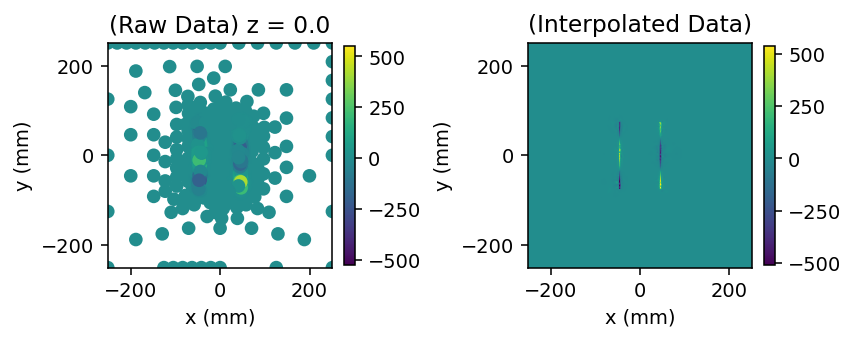

nHat = Vector3<0.0, 0.0, 1.0>


In [9]:
# Process Face 3 of 3
zi     = np.unique(z0)[2]
center = mp.Vector3(z=zi)

# grab fields at current zi face
ind = np.where(z0 == zi)
xi  = x0[ind]
yi  = y0[ind]
Exi = Ex0[ind]
Eyi = Ey0[ind]
Ezi = Ez0[ind]
Hxi = Hx0[ind]
Hyi = Hy0[ind]
Hzi = Hz0[ind]

# define size
Sxi  = max(xi) - min(xi)
Syi  = max(yi) - min(yi)
size = mp.Vector3(Sxi, Syi)

# Plot raw data
fig, ax = plt.subplots(ncols=2, dpi=140, constrained_layout=True)

im = ax[0].scatter(xi, yi, c=Exi.real)
ax[0].set_aspect('equal', 'box')
fig.colorbar(im, ax=ax[0], shrink=0.4)
ax[0].set_xlim([min(xi), max(xi)])
ax[0].set_ylim([min(yi), max(yi)])
ax[0].set_xlabel("x (mm)")
ax[0].set_ylabel("y (mm)")
ax[0].set_title("(Raw Data) z = " + str(zi))

# Interpolate using delaunay triangularization 
Exi = griddata((xi, yi), Exi, (x, y), method='cubic')
Eyi = griddata((xi, yi), Eyi, (x, y), method='cubic')
Ezi = griddata((xi, yi), Ezi, (x, y), method='cubic')
Hxi = griddata((xi, yi), Hxi, (x, y), method='cubic')
Hyi = griddata((xi, yi), Hyi, (x, y), method='cubic')
Hzi = griddata((xi, yi), Hzi, (x, y), method='cubic')

# Plot interpolation
im = ax[1].pcolormesh(x, y, Exi.real)
ax[1].set_aspect('equal', 'box')
fig.colorbar(im, ax=ax[1], shrink=0.4)
# ax[1].set_xlim([np.amin(x), np.amax(x)])
# ax[1].set_ylim([np.amin(y), np.amax(y)])
ax[1].set_xlabel("x (mm)")
ax[1].set_ylabel("y (mm)")
ax[1].set_title("(Interpolated Data)")
plt.show()

field = np.ndarray(shape=(6,Nx,Ny,1), dtype=complex)
field[0,:,:,0] = Exi.T
field[1,:,:,0] = Eyi.T
field[2,:,:,0] = Ezi.T
field[3,:,:,0] = Hxi.T
field[4,:,:,0] = Hyi.T
field[5,:,:,0] = Hzi.T

# update sources
sources += get_equiv_sources(field, src, center, size)

In [10]:
# Simulation
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    sources=sources,
                    force_complex_fields=False,
                    resolution=resolution)

<AxesSubplot:xlabel='X', ylabel='Y'>

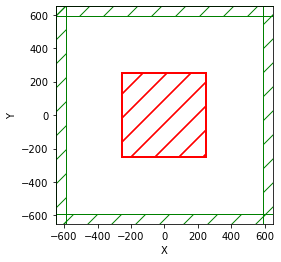

In [11]:
# Test plot of domain
vol = mp.Volume(center=mp.Vector3(), size=mp.Vector3(Sx, Sy, 0))

sim.plot2D(output_plane=vol)

<AxesSubplot:xlabel='X', ylabel='Z'>

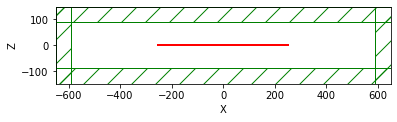

In [12]:
# Test plot of domain
vol = mp.Volume(center=mp.Vector3(), size=mp.Vector3(Sx, 0, Sz))

sim.plot2D(output_plane=vol)

In [13]:
## Run simulation

# Field probe locations
vol = mp.Volume(center=mp.Vector3(z=25), size=mp.Vector3(500, 500, 0))
pt  = mp.Vector3(z=25)

# Simulation time properties
T  = 1/freq
tf = 5 * T
dt = T / 20

Ex = []
Ey = []
Ez = []
Ext = []
Eyt = []
Ezt = []
def updateFields(sim):
    Ex.append(sim.get_array(mp.Ex, vol, cmplx=False))
    Ey.append(sim.get_array(mp.Ey, vol, cmplx=False))
    Ez.append(sim.get_array(mp.Ez, vol, cmplx=False))
    Ext.append(sim.get_array(center=pt, size=mp.Vector3(), component=mp.Ex))
    Eyt.append(sim.get_array(center=pt, size=mp.Vector3(), component=mp.Ey))
    Ezt.append(sim.get_array(center=pt, size=mp.Vector3(), component=mp.Ez))

sim.run(mp.at_every(dt, updateFields), until=tf)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000448942 s
Working in 3D dimensions.
Computational cell is 1300 x 1300 x 300 with resolution 0.2
time for set_epsilon = 7.17258 s
-----------
Meep progress: 2.5/1500.0 = 0.2% done in 7.1s, 4264.4s to go
on time step 1 (time=2.5), 7.11927 s/step
Meep progress: 67.5/1500.0 = 4.5% done in 11.2s, 236.9s to go
on time step 27 (time=67.5), 0.155453 s/step
Meep progress: 132.5/1500.0 = 8.8% done in 15.2s, 156.9s to go
on time step 53 (time=132.5), 0.155376 s/step
Meep progress: 197.5/1500.0 = 13.2% done in 19.2s, 126.9s to go
on time step 79 (time=197.5), 0.155576 s/step
Meep progress: 262.5/1500.0 = 17.5% done in 23.3s, 109.8s to go
on time step 105 (time=262.5), 0.15543 s/step
Meep progress: 327.5/1500.0 = 21.8% done in 27.3s, 97.9s to go
on time step 131 (time=327.5), 0.156149 s/step
Meep progress: 392.5/1500.0 = 26.2% done in 31.4s, 88.6s to go
on time step 157 (time=392.5), 0.155264 s/step
Meep progress: 457.5/1500.

In [14]:
# Find Peaks (discard first half of data due to artificial peaks at start)
ind = int(len(Ex)/2)

Ex_peak = np.amax(np.abs(Ex), axis=0) # need abs here?
Ey_peak = np.amax(np.abs(Ey), axis=0)
Ez_peak = np.amax(np.abs(Ez), axis=0)

# magnitude
E_peak = np.sqrt(Ex_peak**2 + Ey_peak**2 + Ez_peak**2)

# Report peak magnitude
print("Peak field: %.2f V/m" % (np.amax(E_peak)))

Peak field: 17.11 V/m


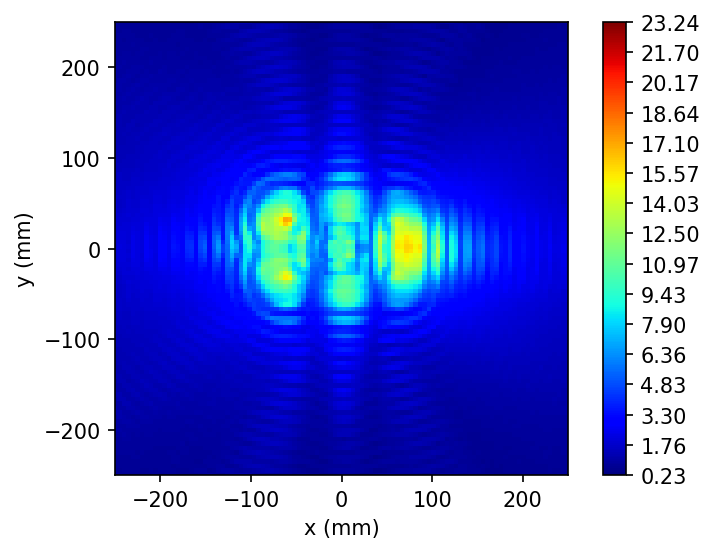

In [15]:
# define axes
x = np.linspace(-vol.size[0]/2, vol.size[0]/2, np.shape(Ex)[1])
y = np.linspace(-vol.size[1]/2, vol.size[1]/2, np.shape(Ex)[2])

# Plot
fig, ax = plt.subplots(dpi=150)
im = ax.pcolormesh(x, y, E_peak, cmap='jet', vmin=0.228, vmax=23.2389)
fig.colorbar(im, ticks=np.linspace(0.228,23.2389, 16))
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
plt.axis([min(x), max(x), min(y), max(y)])
ax.set_aspect('equal', 'box')
plt.show()

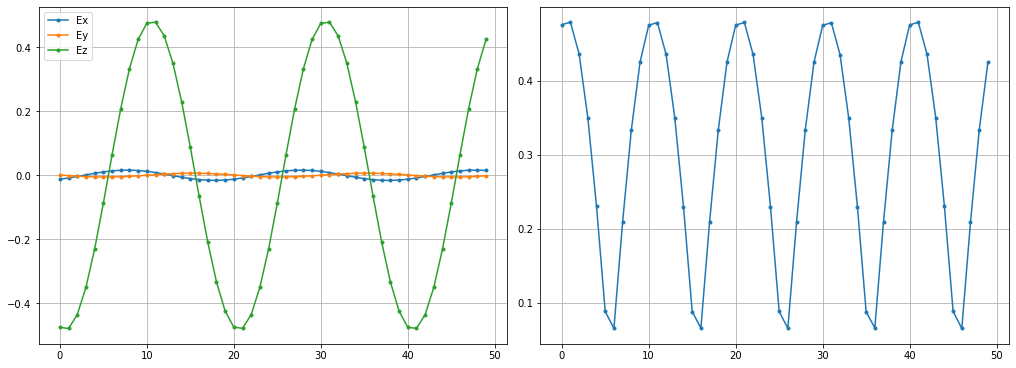

In [16]:
# Plot Time-Domain
fig, ax = plt.subplots(ncols=2, figsize=(14,5), constrained_layout=True)

ax[0].plot(Ext[ind:], '.-', label="Ex")
ax[0].plot(Eyt[ind:], '.-', label="Ey")
ax[0].plot(Ezt[ind:], '.-', label="Ez")
ax[0].legend()
ax[0].grid()

Ext_mag = np.sqrt(np.asarray(Ext)**2 + np.asarray(Eyt)**2 + np.asarray(Ezt)**2)
ax[1].plot(Ext_mag[ind:], '.-')
ax[1].grid()


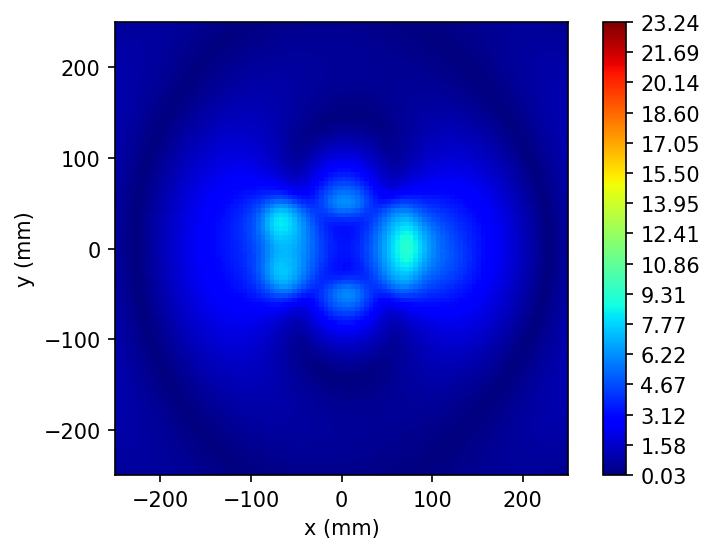

In [17]:
## Animate fields

# calculate E_mag at each time
E_mag = -np.inf * np.ones((np.shape(Ex)))
for i in range(np.shape(Ex)[0]):
    E_mag[i] = np.sqrt(Ex[i]**2 + Ey[i]**2 + Ez[i]**2)

# Animate
fig, ax = plt.subplots(dpi=150)
ims = []
for i in range(len(E_mag)):
    im = ax.pcolormesh(x, y, E_mag[i], animated=True, cmap='jet',
                       vmin=0.0287, vmax=23.2389)
                       # norm=matplotlib.colors.LogNorm(vmin=1., vmax=100.))
    ax.set(xlim=(x[0], x[-1]), ylim=(y[0], y[-1]))
    ax.set_xlabel("x (mm)")
    ax.set_ylabel("y (mm)")
    ax.set_aspect('equal', 'box')
    ims.append([im])

# cbar = fig.colorbar(im)
cbar = fig.colorbar(im, ticks=np.linspace(0.0287, 23.2389, 16))
# cbar.set_clims(1, 20)
# cbar.set_ticks(np.arange(1, 100, 20))
# cbar.set_label("hi")

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat_delay=1000)
ani.save("test.mp4")
Video("test.mp4")